**Проект:  Прогнозирование заказов такси**


---


Описание проекта:

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.


---


Требование к модели:
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Импорт данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

In [2]:
df= pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])

In [3]:
df.set_index('datetime')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


проверим монотонность индексов:

In [5]:
df.index.is_monotonic

True

In [6]:
df = df.set_index('datetime')
df.sort_index(inplace=True)

In [7]:
hour_df = df.resample('1h').mean()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


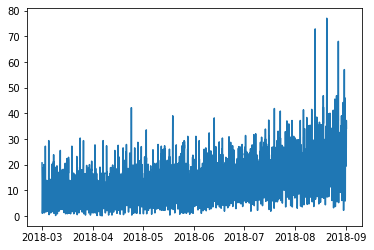

In [8]:
plt = plot(hour_df.index, hour_df.num_orders)

Проверим циклы и сезонности во временном ряду:

In [9]:
decomposed = seasonal_decompose(hour_df)

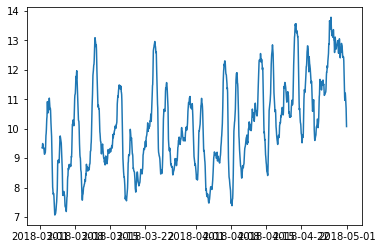

In [12]:
plot(decomposed.trend['2018-03-01':'2018-04'].index, decomposed.trend['2018-03':'2018-04'].num_orders)

У графика тренда меняется среднее, значит ряд не стационарный.

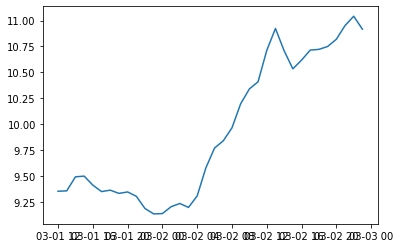

In [13]:
plot(decomposed.trend['2018-03-01 00 ':'2018-03-02 23'].index, decomposed.trend['2018-03-01 00':'2018-03-02 23'].num_orders)


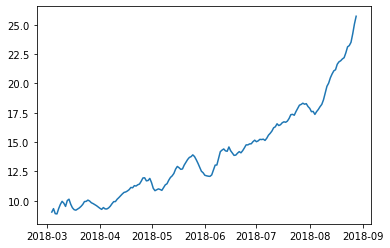

In [14]:
day_df = df.resample('1d').mean()
decomposed = seasonal_decompose(day_df)
plot(decomposed.trend.index, decomposed.trend.num_orders)

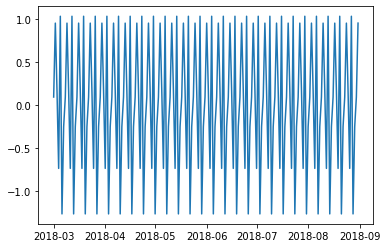

In [15]:
plot(decomposed.seasonal.index, decomposed.seasonal.num_orders)

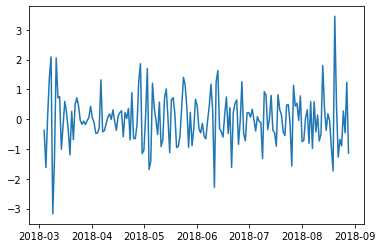

In [16]:
plot(decomposed.resid.index, decomposed.resid.num_orders)

In [17]:
day_df['num_orders'] = day_df - day_df.shift()
day_df['mean'] = day_df['num_orders'].rolling(15).mean()
day_df['std'] = day_df['num_orders'].rolling(15).std()

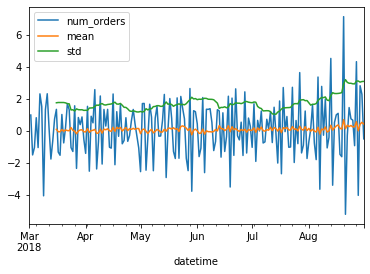

In [18]:
day_df.plot()

In [19]:
day_df = df.resample('1d').mean()

## Обучение моделей

In [20]:
hour_df = df.resample('1h').sum()

Сгенерируем больше признаков для обучения:

In [21]:
def make_features(data, max_lag,rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()



In [22]:
make_features(hour_df, 25, 2)

In [23]:
hour_df = hour_df.dropna()

In [24]:
y = hour_df['num_orders']
X = hour_df.drop(columns=['num_orders'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, shuffle = False)


In [25]:
result_dict = {}

### Baseline. LinearRegression

In [26]:
model_name = 'LinearRegression'
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)
result_dict[model_name] = mean_squared_error(y_test, predictions)**0.5
print(f'{model_name} : {result_dict[model_name]}')

LinearRegression : 45.68738572668911


### DecisionTreeRegressor

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

In [28]:
def fit_predict_result(X_train,y_train,X_test,model, params,n_splits):
    grd = GridSearchCV(model, params, scoring = 'neg_mean_squared_error',cv=TimeSeriesSplit(n_splits=n_splits))
    grd.fit(X_train, y_train)
    model = grd.best_estimator_
    predictions = model.predict(X_test)
    result_dict[model_name] = mean_squared_error(y_test, predictions)**0.5
    return predictions

In [29]:
%%time
model_name = 'DecisionTreeRegressor'
params = {'max_depth' : range(10,30,4), 'min_samples_split' : range(20,80,10), 'min_samples_leaf' : range(4,20,4), 'random_state' : [42]}
fit_predict_result(X_train,y_train,X_test,DecisionTreeRegressor(), params,4)
print(f'{model_name} : {result_dict[model_name]}')
result_dict[model_name]

DecisionTreeRegressor : 49.24845108723241
CPU times: user 17.3 s, sys: 18.7 ms, total: 17.3 s
Wall time: 17.4 s


49.24845108723241

### RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
%%time
model_name = 'RandomForestTreeRegressor'
params = { 'max_depth' : range(6,15,3), 'min_samples_split' : range(4,11,3), 'min_samples_leaf' : range(2,11,2), 'random_state' : [42], 'n_estimators' : [100]}
fit_predict_result(X_train,y_train,X_test,RandomForestRegressor(), params,4)

result_dict[model_name] = mean_squared_error(y_test, predictions)**0.5
print(f'{model_name} : {result_dict[model_name]}')


RandomForestTreeRegressor : 45.68738572668911
CPU times: user 6min 5s, sys: 478 ms, total: 6min 5s
Wall time: 6min 9s


### LGBM

In [33]:
from lightgbm import LGBMRegressor

In [34]:
%%time
model_name = 'LGBMRegressor'
params = {'boosting_type': ['gbdt'], 'max_depth' : range(20,50,10), 'random_state' : [42], 'n_estimators' : [200],'reg_alpha':[0.01,0.1],'reg_lambda':[0.5,0.8]}
predictions = fit_predict_result(X_train,y_train,X_test,LGBMRegressor(), params,4)

print(result_dict[model_name])

41.28939497214491
CPU times: user 13min 17s, sys: 4.89 s, total: 13min 22s
Wall time: 13min 27s


In [36]:
result_df = pd.DataFrame(data =result_dict.values(), columns = ['rmse'], index = result_dict.keys() )
result_df

,rmse
LinearRegression,45.687386
DecisionTreeRegressor,49.248451
RandomForestTreeRegressor,45.687386
LGBMRegressor,41.289395


<Figure size 15000x10000 with 0 Axes>

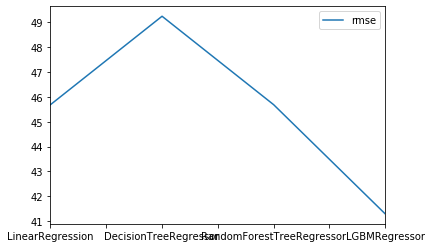

In [37]:
from matplotlib.pyplot import figure
figure(figsize=(150, 100), dpi=100)
result_df.plot()

In [39]:
result_dict

{'LinearRegression': 45.68738572668911,
 'DecisionTreeRegressor': 49.24845108723241,
 'RandomForestTreeRegressor': 45.68738572668911,
 'LGBMRegressor': 41.28939497214491}

In [40]:
pd.DataFrame(result_dict.values(), result_dict.keys(), ['rmse']).sort_values('rmse')

,rmse
LGBMRegressor,41.289395
LinearRegression,45.687386
RandomForestTreeRegressor,45.687386
DecisionTreeRegressor,49.248451


**Вывод:**

Наименьшее значение RMSE получилось при использовании модель lighGBM